In [266]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt

from scipy import stats

from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
import cufflinks as cf

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 8)

np.random.seed(123)

In [267]:
cf.set_config_file(offline=True)

In [2]:
iris = pd.read_csv('../code/data/iris.csv')

In [3]:
colors_dict = dict(zip(iris['species'].unique(), ['red', 'green', 'blue']))
iris['color'] = iris['species'].replace(colors_dict)

In [4]:
df = iris.query("species in ['setosa', 'versicolor']").reset_index(drop=True)

In [5]:
group = 'species'
idx, group_names = df[group].factorize()

In [7]:
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

/Users/divyanshusharma/.pyenvs/numerical-algebra/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/divyanshusharma/.pyenvs/numerical-algebra/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/divyanshusharma/.pyenvs/numerical-algebra/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if n

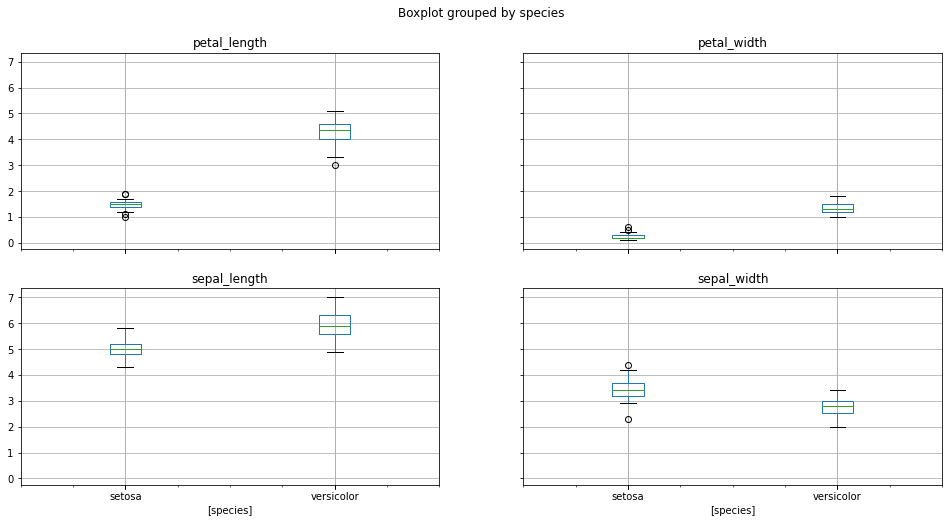

In [8]:
df.boxplot(by='species');

# Linear Regression Model

In [55]:
feature = 'petal_length'

In [97]:
with pm.Model() as lin_reg_model:

    ss = StandardScaler().fit(df[feature].values.reshape(-1, 1))
    x_transformed = ss.transform(df[feature].values.reshape(-1, 1)).squeeze(-1)

#     x = pm.Data('x', df[feature].values)
    x = pm.Data('x', x_transformed)
    y = pm.Data('y', idx)

    # priors
    α = pm.Normal('α', sigma=5)
    β = pm.Normal('β', sigma=5)
    σ = pm.HalfNormal('σ', sigma=10)

    # expected value
    μ = pm.Deterministic('μ', α + β*x)

    # liklihood
    pm.Normal('liklihood', mu=μ, sigma=σ, observed=y)

    # sample posterior
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β, α]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:04<00:00, 421.72draws/s]


In [98]:
lin_reg = az.from_pymc3(model=lin_reg_model, trace=trace)
sampled_vars = ['σ', 'β', 'α']

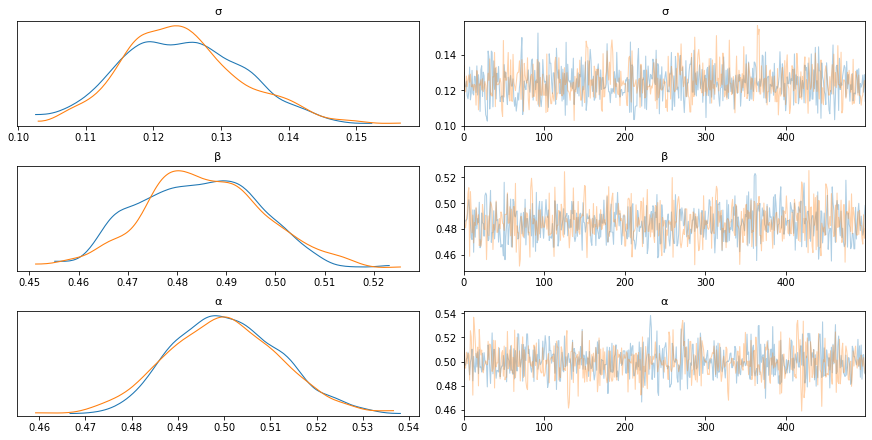

In [104]:
az.plot_trace(lin_reg, var_names=sampled_vars);

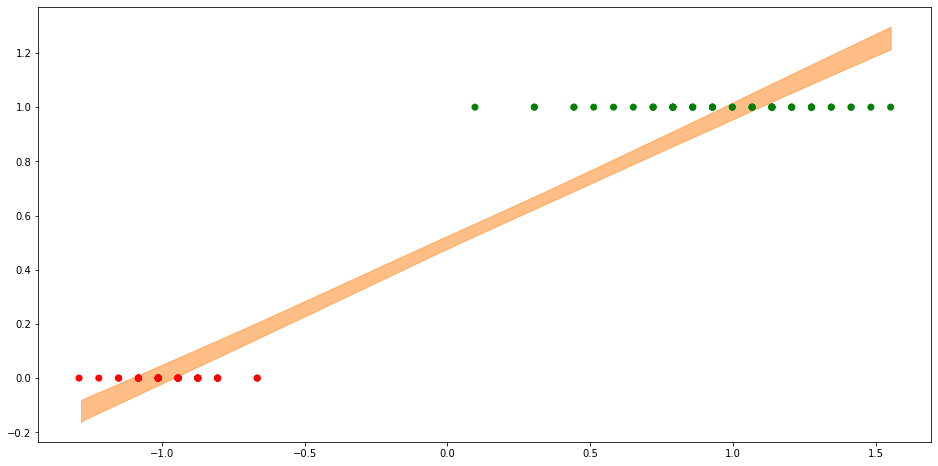

In [106]:
az.plot_hpd(x=lin_reg.constant_data['x'].data, y=lin_reg.posterior['μ'].data)
plt.scatter(x=lin_reg.constant_data['x'].data, y=lin_reg.constant_data['y'].data, c=df['color'].values);

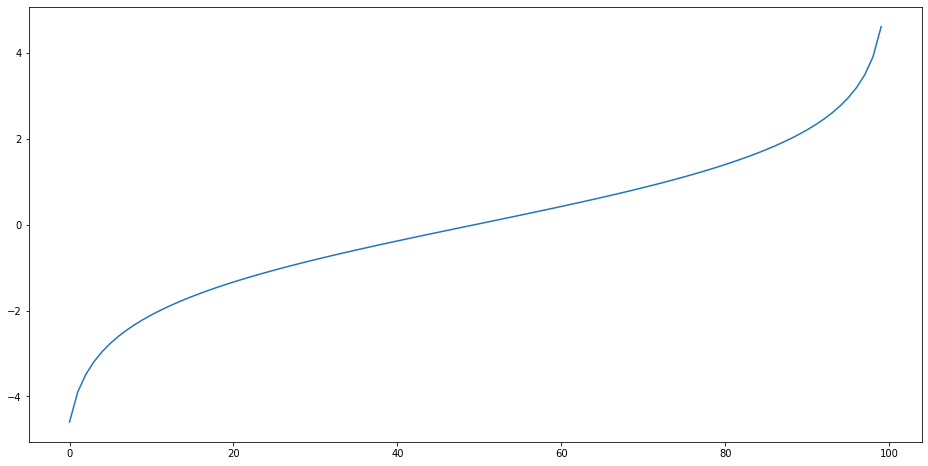

In [22]:
## ideal log-odds

p0 = np.linspace(start=0.99, stop=0, num=100, endpoint=False)
p1 = 1 - p0

y = np.log(p1/p0)
plt.plot(y);

In [41]:
x_temp = np.expand_dims(np.linspace(-2, 2, 10), axis=1) # (-2, 2) range taken because x are standardised
np.repeat(x_temp, repeats=0, axis=1)

array([], shape=(10, 0), dtype=float64)

# Logistic Regression Model

## Feature Comparison

In [7]:
datasets = {}
p_threshold = 0.5

for feature in features:
    with pm.Model() as log_reg_model:

        ss = StandardScaler().fit(df[feature].values.reshape(-1, 1))
        x_transformed = ss.transform(df[feature].values.reshape(-1, 1)).squeeze(-1)

    #     x = pm.Data('x', df[feature].values)
        x = pm.Data('x', x_transformed)
        y = pm.Data('y', idx)

        # priors
        α = pm.Normal('α', sigma=10)
        β = pm.Normal('β', sigma=10)

        # log-odds
        π = pm.Deterministic('π', α + β*x)
        
#         # decision boundary
#         lo_threshold = np.log(p_threshold/(1 - p_threshold))

#         if x.shape[1] > 1:
#             x_temp = np.expand_dims(np.linspace(-2, 2, 1000), axis=1) # (-2, 2) range taken because x are standardised
#             X_temp = np.repeat(x_temp, repeats=x.shape[1] -1, axis=1)
#             Σ = pm.math.sum(pm.math.matrix_dot(X_temp, β))
#         else:
#             Σ = 0
                    
#         x_k = (lo_threshold - α - Σ)/β[-1]
#         δ = pm.Deterministic('δ', x_k)

        # logistic transformation
        ß = pm.Deterministic('ß', pm.math.sigmoid(π))

        # liklihood
        pm.Bernoulli('liklihood', p=ß, observed=y)

        # sample posterior
        trace = pm.sample(progressbar=False)
        datasets[feature] = az.from_pymc3(model=log_reg_model, trace=trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200

In [14]:
sampled_vars = ['β', 'α']

In [15]:
az.compare(dataset_dict=datasets)

/Users/divyanshusharma/.pyenvs/numerical-algebra/lib/python3.7/site-packages/arviz/stats/stats.py:532: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/divyanshusharma/.pyenvs/numerical-algebra/lib/python3.7/site-packages/arviz/stats/stats.py:532: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and hig

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
petal_length,0,-0.444374,0.104473,0,0.502005,6.16281,0,True,log
petal_width,1,-0.459969,0.116326,0.0155946,0.497995,7.14023,0.288842,True,log
sepal_length,2,-34.4162,2.27359,33.9718,5.22254e-12,0.216056,5.98837,False,log
sepal_width,3,-38.2054,2.68848,37.761,3.45215e-13,0.210027,7.30195,False,log


## Prior Comparison

### Gaussian Prior

In [ ]:
feature = 'petal_width'
p_threshold = 0.5

with pm.Model() as log_reg_model:

    x_transformed = StandardScaler().fit_transform(df[feature].values.reshape(-1, 1)).squeeze(-1)

#     x = pm.Data('x', df[feature].values)
    x = pm.Data('x', x_transformed)
    y = pm.Data('y', idx)

    # priors
    α = pm.Normal('α', sigma=5)
    β = pm.Normal('β', sigma=5)
    
    # decision boundary
    lo_threshold = np.log(p_threshold/(1 - p_threshold))

    if x.ndim > 1 and x.shape.eval()[1] > 1:
        x_temp = np.expand_dims(np.linspace(-2, 2, 1000), axis=1) # (-2, 2) range taken because x are standardised
        X_temp = np.repeat(x_temp, repeats=x.shape[1] -1, axis=1)
        Σ = pm.math.sum(pm.math.matrix_dot(X_temp, β))
    else:
        Σ = 0

    x_k = (lo_threshold - α - Σ)/β
    δ = pm.Deterministic('δ', x_k)

    # log-odds
    π = pm.Deterministic('π', α + β*x)

    # logistic transformation
    ß = pm.Deterministic('ß', pm.math.sigmoid(π))

    # liklihood
    pm.Bernoulli('liklihood', p=ß, observed=y)

    # sample posterior
    trace = pm.sample()

In [32]:
sampled_vars = ['β', 'α']

In [ ]:
az.plot_trace(trace, var_names=sampled_vars);

In [104]:
δ_hpd = az.hpd(trace['δ'], credible_interval=0.95);
plt.fill_betweenx(y=[0, 1], x1=δ_hpd[0], x2=δ_hpd[1], color='k', alpha=0.3);

az.plot_hpd(x=x.eval(), y=trace['ß'], credible_interval=0.95);
plt.vlines(x=trace['δ'].mean(), ymin=0.0, ymax=1.0);


### Student-t Prior

In [118]:
feature = 'petal_width'
p_threshold = 0.5


with pm.Model() as log_reg_model:

    ss = StandardScaler().fit(df[feature].values.reshape(-1, 1))
    x_transformed = ss.transform(df[feature].values.reshape(-1, 1)).squeeze(-1)

#     x = pm.Data('x', df[feature].values)
    x = pm.Data('x', x_transformed)
    y = pm.Data('y', idx)

    # priors
    α = pm.StudentT('α', sigma=5, nu=50)
    β = pm.StudentT('β', sigma=5, nu=50)
    
    # decision boundary
    lo_threshold = np.log(p_threshold/(1 - p_threshold))
    x_k = (lo_threshold - α)/β
    δ = pm.Deterministic('δ', x_k)

    # log-odds
    π = pm.Deterministic('π', α + β*x)

    # logistic transformation
    ß = pm.Deterministic('ß', pm.math.sigmoid(π))

    # liklihood
    pm.Bernoulli('liklihood', p=ß, observed=y)

    # sample posterior
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
Sampling 2 chains, 1 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 690.49draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [119]:
sampled_vars = ['β', 'α']

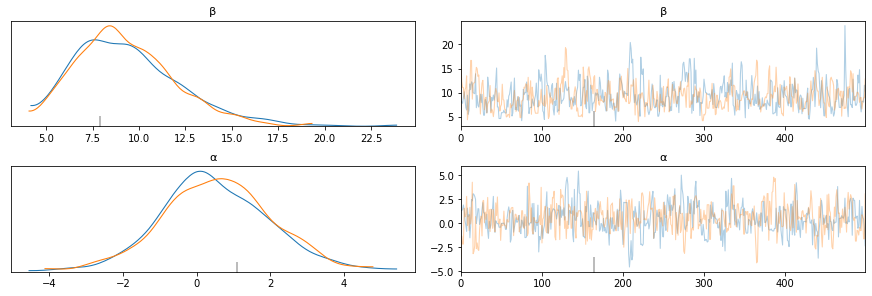

In [120]:
az.plot_trace(trace, var_names=sampled_vars);

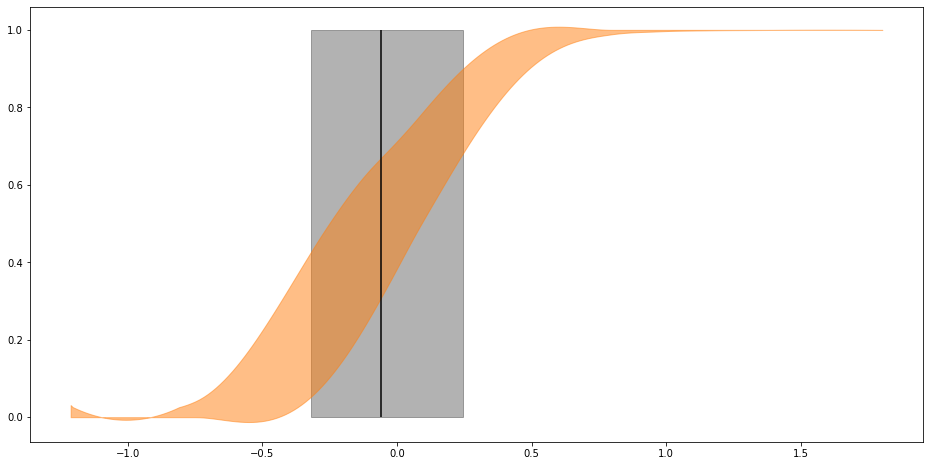

In [121]:
δ_hpd = az.hpd(trace['δ'], credible_interval=0.95);
plt.fill_betweenx(y=[0, 1], x1=δ_hpd[0], x2=δ_hpd[1], color='k', alpha=0.3);

az.plot_hpd(x=x.eval(), y=trace['ß'], credible_interval=0.95);
plt.vlines(x=trace['δ'].mean(), ymin=0.0, ymax=1.0);

## Multiple Features

In [125]:
p_threshold = 0.5
feature = ['sepal_length', 'sepal_width']

with pm.Model() as log_reg_model:

    X_transformed = StandardScaler().fit_transform(df[feature].values)

#     X = pm.Data('X', df[feature].values)
    X = pm.Data('X', X_transformed)
    y = pm.Data('y', idx)

    # priors
    α = pm.Normal('α', sigma=5)
    β = pm.Normal('β', sigma=5, shape=X.shape.eval()[1])
    
    # decision boundary
    lo_threshold = np.log(p_threshold/(1 - p_threshold))

    if X.ndim > 1 and X.shape.eval()[1] > 1:
        x_temp = np.expand_dims(np.linspace(-2, 2, X.shape.eval()[0]), axis=1) # (-2, 2) range taken because x are standardised
        X_temp = np.repeat(x_temp, repeats=X.shape.eval()[1] - 1, axis=1)
#         Σ = pm.math.sum(pm.math.matrix_dot(X_temp, β[:-1]))
        Σ = pm.math.matrix_dot(X_temp, β[:-1])
    else:
        Σ = 0
        
    # values of the decision boundary for the last feature 
    x_k = (lo_threshold - α - Σ)/β[-1] 
#     X_bd = np.stack([X_temp, x_k], axis=1)
    δ = pm.Deterministic('δ', x_k)

    # log-odds
    π = pm.Deterministic('π', α + pm.math.dot(X, β))

    # logistic transformation
    ß = pm.Deterministic('ß', pm.math.sigmoid(π))

    # liklihood
    pm.Bernoulli('liklihood', p=ß, observed=y)

    # sample posterior
    trace = pm.sample()
    ppc = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]
100%|██████████| 1000/1000 [00:17<00:00, 58.28it/s]


In [123]:
## shape-sanity checks

# b = β.random() 
# Σ = pm.math.matrix_dot(X_temp, b[:-1])
# ((lo_threshold - α.random() - Σ)/b[-1]).shape.eval()

# (α.random() + pm.math.dot(X, β.random())).eval().shape
# β.random().shape

In [126]:
sampled_vars = ['β', 'α']
multi_feature = az.from_pymc3(model=log_reg_model, trace=trace, posterior_predictive=ppc)

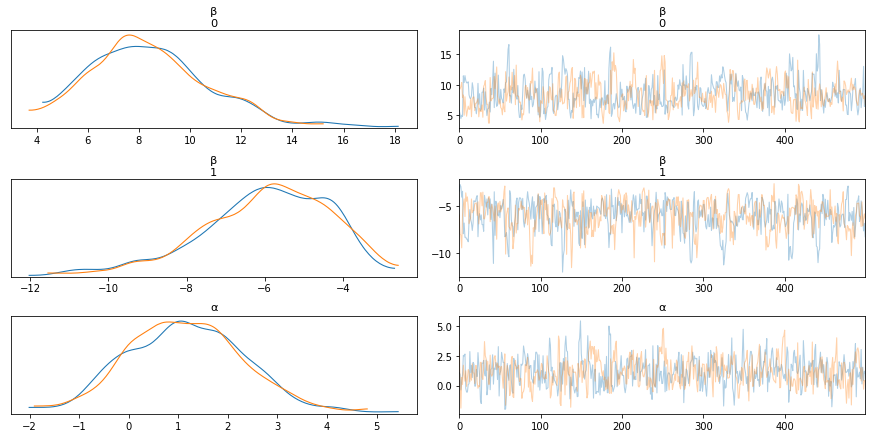

In [127]:
az.plot_trace(multi_feature, var_names=sampled_vars);

In [80]:
x1, x2 = np.split(multi_feature.constant_data['X'].data, axis=1, indices_or_sections=len(feature))

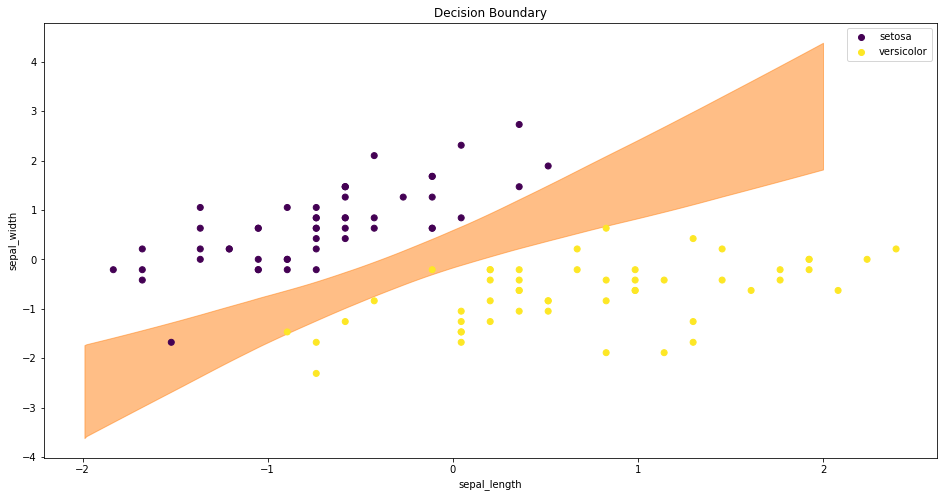

In [103]:
az.plot_hpd(x=np.linspace(-2, 2, 100), y=multi_feature.posterior['δ'], credible_interval=0.95);
scatter = plt.scatter(x=x1, y=x2, c=idx);

plt.xlabel(feature[0]);
plt.ylabel(feature[1]);
plt.title('Decision Boundary');

plt.legend(handles=scatter.legend_elements()[0], labels=group_names.to_list());

## Analysis

In [137]:
std_scaler = StandardScaler().fit(df[feature].values)

In [138]:
std_scaler.mean_, std_scaler.scale_, 

(array([5.471, 3.099]), array([0.63848179, 0.47633916]))

In [139]:
# Z scores of both features
z1, z2 = np.split(multi_feature.constant_data['X'].data, axis=1, indices_or_sections=len(feature))

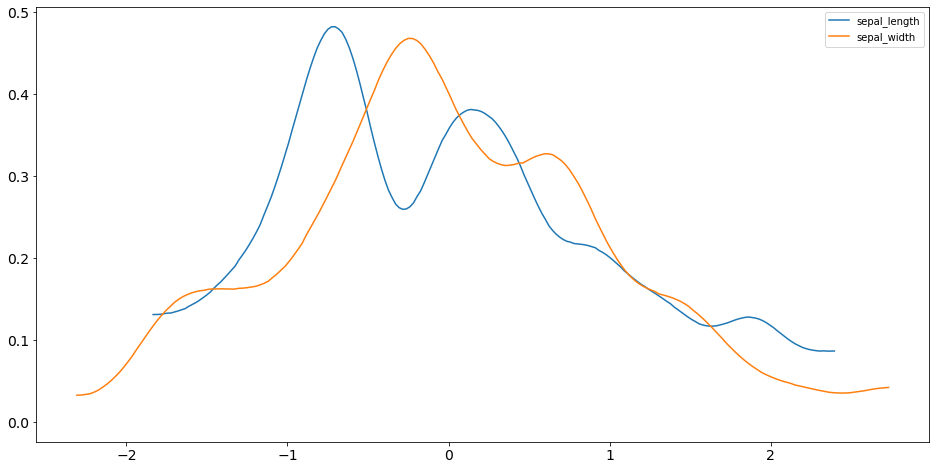

In [151]:
az.plot_dist(z1, label=feature[0]);
az.plot_dist(z2, label=feature[1]);
plt.legend();

In [145]:
x1, x2 = np.split(std_scaler.inverse_transform(multi_feature.constant_data['X'].data), axis=1, indices_or_sections=len(feature))

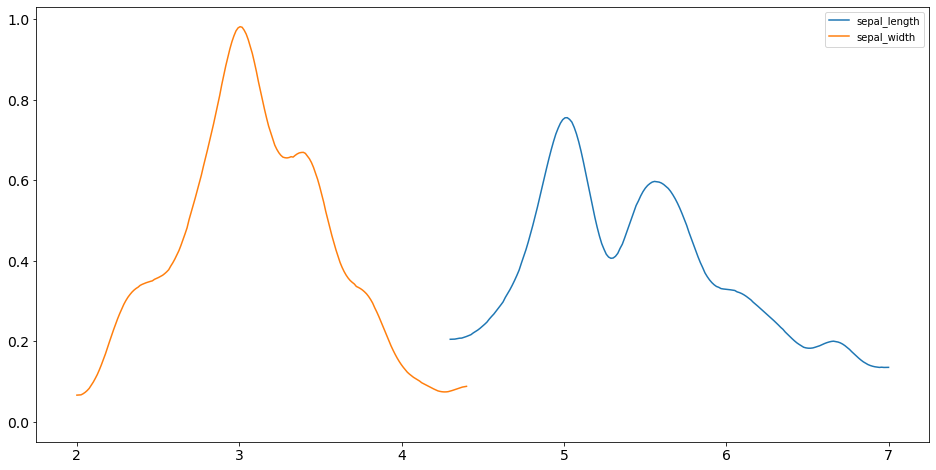

In [153]:
az.plot_dist(x1, label=feature[0]);
az.plot_dist(x2, label=feature[1]);
plt.legend();

In [161]:
z1_fake = np.arange(-3, 3, 0.1)
z2_fake = np.arange(-3, 3, 0.1)
z_fake = np.stack([z1_fake, z2_fake], axis=1)

In [162]:
x_fake = std_scaler.inverse_transform(z_fake)
x1_fake, x2_fake = np.split(x_fake, axis=1, indices_or_sections=len(feature))

In [178]:
X.set_value(z_fake)
prediction = pm.sample_posterior_predictive(trace=trace, model=log_reg_model, var_names=['π', 'ß', 'δ', 'liklihood'])

100%|██████████| 1000/1000 [00:19<00:00, 50.24it/s]


### Probability

In [210]:
ß_mean = prediction['ß'].mean(axis=0)

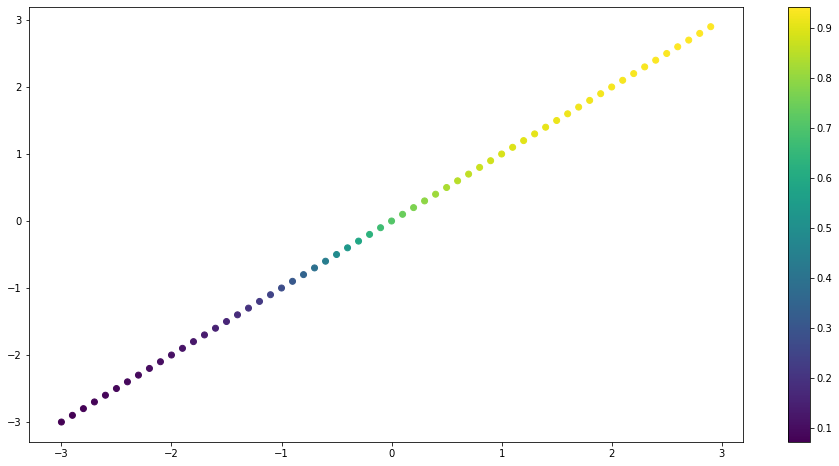

In [212]:
plt.scatter(z1_fake, z2_fake, c=ß_mean, cmap='viridis');
plt.colorbar();

In [283]:
i, j  = np.meshgrid(z1_fake, z2_fake)

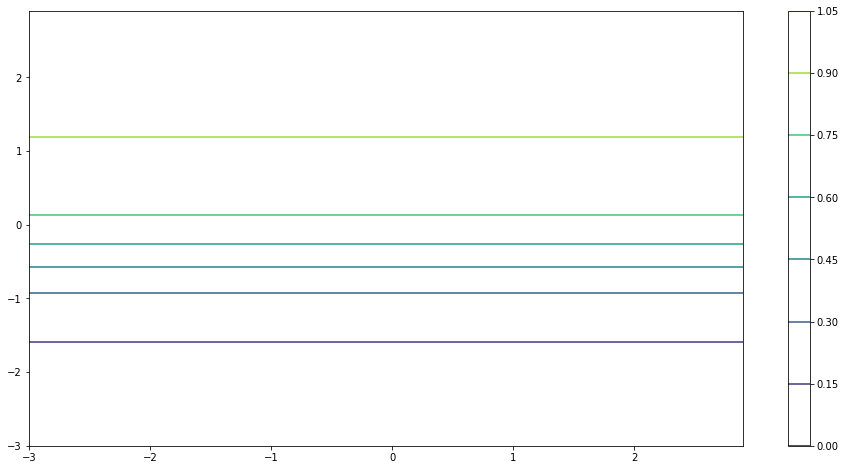

In [285]:
plt.contour(i, j, np.repeat(ß_mean.reshape(-1, 1), repeats=60, axis=1));
plt.colorbar();

### Log-Odds

In [282]:
π_mean = prediction['π'].mean(axis=0)

In [283]:
i, j  = np.meshgrid(z1_fake, z2_fake)

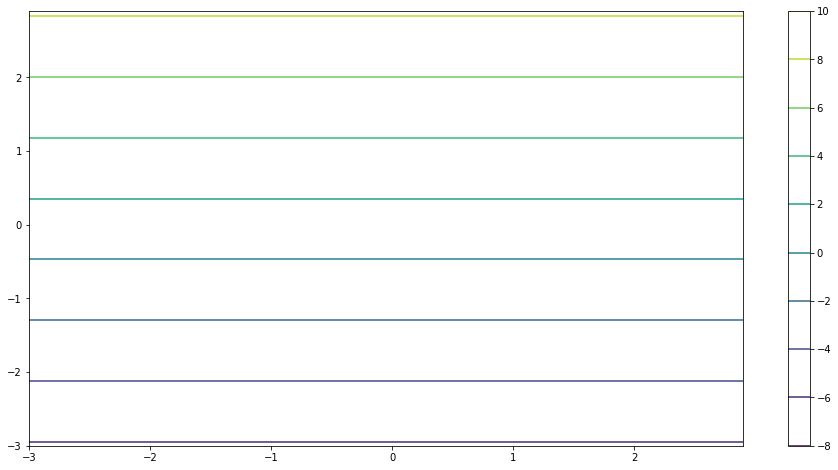

In [284]:
plt.contour(i, j, np.repeat(π_mean.reshape(-1, 1), repeats=60, axis=1));
plt.colorbar();

In [259]:
out = pd.DataFrame({'x': z1_fake, 'y': z2_fake, 'z':π_mean})

In [281]:
# fig = out.iplot(kind='scatter', x='x', y='y')

# Appendix

## Dealing with imbalanced class sizes

## Linear Discriminant Ananlysis

## Softmax Regression